In [1]:
# Yuchen ZHU, Feb 2020
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
import time
import pickle
import numba



In [2]:
# initialize some useful variables, change these for gas cases
'''
Liquid :
---------
    L = 30
    cutOff = 14

Gas :
------
    L = 182
    cutOff = 50

temperature :
-------------
    100, 200, 300, and 400
'''

state = 'liquid'

if state == 'gas':
    L = 182 # box size    30 182
    cutOff = 50 #[A]    14 50
elif state == 'liquid':
    L = 30 # box size    30 182
    cutOff = 14 #[A]    14 50    
elif state == 'gas_special':
    L = 75
    cutOff = 14

sigma = 3.73 #3.73
epsilon = 148 #148
# L = 182 # 30 75 182
# cutOff = 50 # 14 50 
Npart = 362 # 153 362
temperature = 150
kb = 1.38064852E-23   #[j/k]
energyTail = 1/3 * (sigma/cutOff)**9 - (sigma/cutOff)**3
energyTail *= 8/3 * np.pi * (Npart/L**3) * epsilon * sigma**3 
energyTail *= Npart # tail energy is particle property


# Load data
def loadData():
    x, y, z = [], [], []
    cnt = 0
    with open("box3.xyz", "r") as obj:
        for line in obj:
            cnt += 1
            if cnt > 2:
                lines = line.split()
                x.append(float(lines[1]))
                y.append(float(lines[2]))
                z.append(float(lines[3]))
    coords = np.array([x, y, z])
    return coords

#coordinates of particles
coords = loadData()

 

In [3]:
# functions for rdf computing
# ===================================================================

def write_xyz_traj(r, Npart, filename):
	'''
		This function appends a frame to the end of a xyz file. 
		
		: r : 			position of the particles in the form of [[x1,y1,z1],[x2,y2,z2] ... [xN,yN,zN]]
		: Npart :		number of particles (int)
		: filename :	name of the trajectory file where the frame gets appended (str)

	'''
	output_box0 = open(filename + '.xyz', 'a')
	output_box0.write('%0.0i\n\n' % Npart)
	[output_box0.write('%s\t%0.5f\t%0.5f\t%0.5f\n' % ("C", r[i, 0], r[i, 1], r[i, 2])) for i in range(0, Npart)]
	output_box0.close()
    
def read_xyz_trj(file_name):

    xyz_file = open(file_name, 'r')

    frame = 0
    xyz = {}
    READING=True
    while READING:
        try:
            nparts = int(xyz_file.readline())
            xyz_file.readline()
            xyz[frame] = np.zeros([nparts, 3])
            for k in range(0, nparts):
                line = xyz_file.readline()
                line = line.split()
                xyz[frame][k, 0] = line[1]
                xyz[frame][k, 1] = line[2]
                xyz[frame][k, 2] = line[3]
            frame += 1
        except:
            print("Reach end of '" + file_name + "'")
            READING=False

    return xyz

# @numba.jit(nopython=True)
def rdf(xyz, LxLyLz, n_bins=100, r_range=(0.01, 10.0)):
    '''
    rarial pair distribution function

    :param xyz: coordinates in xyz format per frame
    :param LxLyLz: box length in vector format
    :param n_bins: number of bins
    :param r_range: range on which to compute rdf
    :return:
    '''

    g_r   = np.histogram(0, bins=n_bins, range=r_range)[0]
    edges = np.histogram(0, bins=n_bins, range=r_range)[1]
    g_r[0] = 0
    g_r = g_r.astype(np.float64)
    rho = 0
    
    for i, xyz_i in enumerate(xyz):
        xyz_j = np.vstack((xyz[:i], xyz[i + 1:]))
        d = np.abs(xyz_i - xyz_j)
        d = np.where(d > 0.5 * LxLyLz, LxLyLz - d, d)                    
        d = (np.sum(d ** 2, axis=-1))**0.5
        temp_g_r = np.histogram(d, bins=n_bins, range=r_range)[0]
        g_r += temp_g_r

    rho += (i + 1) / np.prod(LxLyLz)
    r = 0.5 * (edges[1:] + edges[:-1])
    V = 4./3. * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    norm = rho * i
    g_r /= norm * V

    return r, g_r


In [4]:
@numba.jit(nopython=True) 
def totalEnergy(coords):
    '''
    Inputs:
    ---------
    [0] : array of (3,362)
        the coordinates of the system
    
    Output:
    --------------
    [0] : float, 
        the total energy of lj potential, kinetic energy omit
        
    [1] : float, 
        total virialPre of the system
        
    parameters:
    ------------
    temp0 : float, 
        the lj potential for each pair
        
    temp1 : 
        float, the second term in virial presuure
    '''
    
    energyLj = 0
    virialPre = Npart * temperature
    
    for i in range(Npart):
        for j in range(i + 1):
            
            # sign multiple values at one time will solw numba greatly 
            dx = abs(coords[0, i] - coords[0, j])
            dy = abs(coords[1, i] - coords[1, j])
            dz = abs(coords[2, i] - coords[2, j])           
            if dx > (0.5 * L):
                dx = L - dx
            if dy > (0.5 * L):
                dy = L - dy
            if dz > (0.5 * L):
                dz = L - dz
            r = (dx*dx + dy*dy + dz*dz)**0.5
            
            if r < cutOff and r > 0:
                temp0 = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
                temp1 = 4 * epsilon * ( 4*(sigma/r)**12 - 2*(sigma/r)**6 )
                energyLj += temp0
                virialPre += temp1
                
    # multipy (kb*rho) for virial pressure [Pa]
    virialPre *= kb/(L*10**-10)**3 
    
    return energyLj + energyTail  , virialPre*1e-6  # [K] and [MPa]

totalEnergy(coords)

(-260605.77496876116, 5.5349418397059935)

In [5]:
@numba.jit(nopython=True) 
def singleParticleEnergy(onePart, coords):
    '''
    Inputs:
    --------
    [0]: array of (3,1) 
         the coordinates of the choosen one
    [1]: shape (3, 362) array 
         the coordinates of the system
    
    Outputs:
    ---------
    [0]: float 
         total lj potential of the single particle system
    [1]: float 
         total virial pressure of the system
    '''
    
    energyLj = 0
    virialPre =  Npart * temperature
    for i in range(Npart):
#         distance = abs(onePart - coords[:,i])
#         #pbc
#         distance = np.where( distance > 0.5*L, L - distance, distance )          
#         r = np.linalg.norm(distance)
        
#         dx, dy, dz = abs(onePart - coords[:, i])
        dx = abs(onePart[0] - coords[0, i])
        dy = abs(onePart[1] - coords[1, i])
        dz = abs(onePart[2] - coords[2, i])
        
        if dx > (0.5 * L):
            dx = L - dx
        if dy > (0.5 * L):
            dy = L - dy
        if dz > (0.5 * L):
            dz = L - dz
        r = (dx*dx + dy*dy + dz*dz)**0.5                
        if r < cutOff and r > 0:
            temp0 = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
            temp1 =  4 * epsilon * ( 4*(sigma/r)**12 - 2*(sigma/r)**6 )
            energyLj += temp0
            virialPre += temp1
                       
    virialPre *= kb/(L*10**-10)**3  
    return energyLj + energyTail/Npart, virialPre 

onePart = np.array([25.852, 18.878, 11.774])
singleParticleEnergy(onePart , coords )


(-1096.6292782559278, 28885432.105749108)

In [6]:
@numba.jit(nopython=True) 
def translate(coords, deltaMax):
    '''
    Inputs:
    -------
    [0] : (3,362) array, 
          old coordinates not global variable
    [1] : int 
          walker step
    
    Outputs:
    ----------
    [0] : array shape(3,362), 
          coordinates after this transform
    [1] : float, 
          acceptProbability of one step 
    
    parameters:
    ---------------
    coordsUpdate : (3,362) array, 
                   the coordinates after trial move
    '''
    
    #initialize some useful variables
    acc = 0
    beta = 1/(kb*temperature)
    
    #step1 select one random particle
    rolldice = np.random.randint(0, Npart) #pick one particle
    coordsOld = coords[:, rolldice]
    
    #step2 give random displacement to the particle
    coordsNew = coordsOld + np.random.uniform(-deltaMax, deltaMax, size = 3) 
    
    #step3 check if this walker is out side the boundry    
    for i in range(3):
        if coordsNew[i] < 0:
            coordsNew[i] += L
        if coordsNew[i] > L:
            coordsNew[i] -= L 
    
    # update the coords into coordsUpdate
    coordsUpdate = coords.copy()
    coordsUpdate[:, rolldice] = coordsNew 
    
    #step4 compute energyOld and energyNew for one particle
    singleEnergyOld = singleParticleEnergy(coordsOld, coords)[0]
    singleEnergyNew = singleParticleEnergy(coordsNew, coordsUpdate)[0]
    
    #step5 compute the energy difference
    energyDifference = kb*(singleEnergyNew - singleEnergyOld) #convert into J
    
    #step6 accept the trial move?
    if -beta*energyDifference > 0:
        acc = 1
        acceptProbability = 1
    else:
        acceptProbability = min(1, np.exp(-beta*energyDifference))
        if acceptProbability > np.random.uniform(0,1):
            acc = 1
                    
    #step7 return values
    if acc == 1:
        return coordsUpdate, acceptProbability
    if acc == 0:
        return coords, acceptProbability

translate(coords, 0.5)





(array([[25.852,  7.176,  1.807, ..., 27.866, 14.5  ,  0.668],
        [18.878, 21.173, 17.474, ...,  9.805, 24.18 ,  0.742],
        [11.774,  7.061, 22.317, ..., 27.936, 20.021, 16.143]]), 1.0)

In [7]:
@numba.jit(nopython=True) 
def startConf(deltaMax, moves):
    '''
    Inputs :
    ---------
    [0] : float, 
          walker step
    [1] : int, 
          number of translation moves
       
    Outputs :
    ---------
    [0] : array of (3, 362) 
        coords after (moves) times translation
    [1] : float
        the avg accepted prob in these translation
        
    param :
    --------
    temp : float
        accept probability of each move
    
    start from random postions and translate moves times. 
    '''
    avgAccProb = 0
    coords = np.random.uniform(0, L, size = 3*Npart).reshape(3, Npart)
    for i in range(moves):
        coords, temp = translate(coords, deltaMax)
        avgAccProb += temp
        
    avgAccProb = avgAccProb/moves
    return coords,avgAccProb





In [8]:
@numba.jit(nopython=True) 
def averages(variableHistory):
    '''
    Inputs:
    ---------
    [0] : array of (n,)
    An array containing history of the concerned variable 
    
    
    Outputs:
    -----------
    [0] : float, 
        average of the array     
    [1] : float,
        standard deviation of the array
    
    '''
    
    avg = np.mean(variableHistory)
    var = np.mean( (variableHistory - avg)**2 )
    sd = var**0.5
    
    return avg, sd
    



500000 cycles cost 900.85 seconds
Average total pressure of liquid 150 [K] is 9.1078 [MPa]
Average energy is -260219.94 [K], standard deviation is 2261.59 [K]


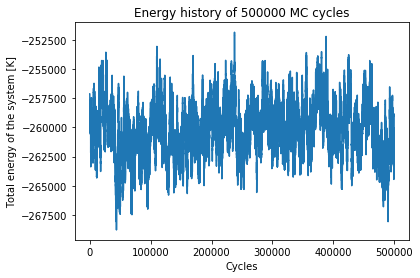

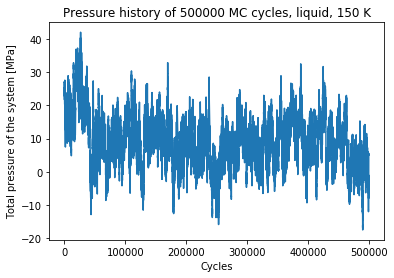

In [9]:
# @numba.jit(nopython=True) 
def MCNVT(cycles):
    '''
    
    parameters:
    -----------
    
    totalEnergyHistory : (cycles+1) array, 
        contain energy history for the whole simulation
        
    totalPressureHistory : (cycles+1) array,
        contain pressure history for the whole simulation
        
    accProbHistory : (cycles) array,
        contain the accept probability for the whole simulation
    
    
    Instructions:
    ------------
        compute total energy/pressure history separately, or it will double
        computer power. Comment out totalEnergyHistory[i+1] option for computing
        presure, comment out totalPressureHistory[i+1] option for computing
        energy, also change the the plot content in the plotting code accordingly.
        Time cost of 500000 MC cycles is around 6 [mins] for liquid, 3[mins]
        for gas. 
    
        The resulting figure could be either energy [K] or pressure [MPa] history of MC 
        simulations, depending on the calculation option one chooses
    '''
    # initial some useful data
    sumAccProb = 0
    totalEnergyHistory = np.zeros(cycles+1)
    totalPressureHistory = np.zeros(cycles+1)
    accProbHistory = np.zeros(cycles)
    coordsTemp = startConf(0.6, 32000)[0] 
    
    # compute initial varibles
    totalEnergyHistory[0], totalPressureHistory[0] = totalEnergy(coordsTemp)   
    
    # MC loop
    for i in range(cycles):
        
        # do translation
        coordsTemp, accProb = translate(coordsTemp, 0.6)
        
        # sample the energy       
        totalEnergyHistory[i+1] = totalEnergy(coordsTemp)[0]
        
        # sample the pressure
        totalPressureHistory[i+1] = totalEnergy(coordsTemp)[1]     
        
        # the accept ratio history
        accProbHistory[i] = accProb        

        # save coords for rdf plot
        if i%500 == 0 :
            write_xyz_traj(coordsTemp.T, Npart, state + str(temperature))
    
    # compute the statistics of the energy history
    meanEnergy, stEnergy = averages(totalEnergyHistory)
    
    # compute avg total pre
    avgTotalPre = averages(totalPressureHistory)[0]
    
    #plot energy
    plt.figure()
    plt.title("Energy history of {} MC cycles".format(cycles))
    plt.plot(np.arange(cycles + 1), totalEnergyHistory)
    plt.xlabel('Cycles')
    plt.ylabel('Total energy of the system [K]')

    #plot pressure
    plt.figure()
    plt.title("Pressure history of %i MC cycles, %s, %i K" %(cycles, state, temperature) )
    plt.plot(np.arange(cycles + 1), totalPressureHistory)
    plt.xlabel('Cycles')
    plt.ylabel('Total pressure of the system [MPa]')
    plt.savefig('preHistory_%s%i.png'%(state,temperature))
    
    #save the data
    data = {'totalEnergyHistory': totalEnergyHistory, 
            'totalPressureHistory':totalPressureHistory,
            'accProbHistory': accProbHistory,
            'avgTotalPre': avgTotalPre}
    pickle.dump( data, open('pre200.dat', 'wb') )
    
    
    return meanEnergy, stEnergy, avgTotalPre


cycles = 500000
start = time.time()

meanEnergy, stEnergy, avgTotalPre = MCNVT(cycles)

stop = time.time()   
print("{} cycles cost {:.2f} seconds".format(cycles, stop-start))
print('Average total pressure of %s %i [K] is %.4f [MPa]' %(state ,temperature, avgTotalPre))
print('Average energy is {:.2f} [K], standard deviation is {:.2f} [K]'.format(meanEnergy, stEnergy))

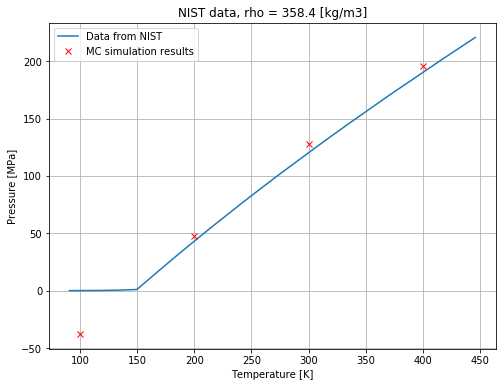

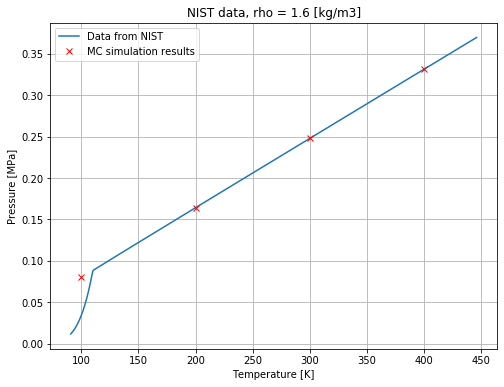

In [10]:


def NIST358():
    '''
    Instructions:
    -------------
        Data were produced by MCNVT() function under different temperatures 
        
    '''
    T, P = np.zeros(400), np.zeros(400)
    i = 0
    with open("NIST358.txt", "r") as file:
        for line in file:
            line = line.split()
            T[i] = line[0]
            P[i] = line[1]
            i += 1
            if i>399: 
                break
    
    # wanted temperature
    Tmc358 = np.array([100, 200, 300, 400])
    Pmc358 = np.array([-37.7435, 47.5158, 127.6414, 195.6832 ])
    
    # plot the figure
    plt.figure(figsize = (8,6))
    plt.title("NIST data, rho = 358.4 [kg/m3]")
    plt.plot(T, P, label = 'Data from NIST')
    plt.plot(Tmc358, Pmc358, 'rx',label = 'MC simulation results')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Pressure [MPa]')
    plt.legend(); plt.grid()

NIST358()

def NIST1():
    T, P = np.zeros(400), np.zeros(400)
    i = 0
    with open("NIST1.txt", "r") as file:
        for line in file:
            line = line.split()
            T[i] = line[0]
            P[i] = line[1]
            i += 1
            if i>399: 
                break
    
    # wanted temperature
    Tmc1 = np.array([100, 200, 300, 400])
    Pmc1 = np.array([0.0805, 0.1642, 0.2479, 0.3316 ])
    
    # plot the figure
    plt.figure(figsize = (8,6))
    plt.title("NIST data, rho = 1.6 [kg/m3]")
    plt.plot(T, P, label = 'Data from NIST')
    plt.plot(Tmc1, Pmc1, 'rx',label = 'MC simulation results')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Pressure [MPa]')
    plt.legend(); plt.grid()


NIST1()




Reach end of 'liquid150.xyz'
cost 63.59 seconds


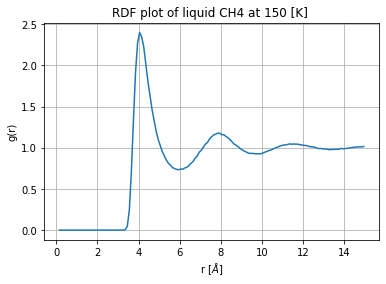

In [11]:

def rdfplot(T):
    '''
    reading state rdf cost 5mins for 5000 frames
    '''
    
    nbins = 149
    gr = np.zeros(nbins)
    LXLYLZ = np.array([L, L, L])
    if state == 'liquid':
        rdfRange = (0.1, 15.0)
    elif state == 'gas':
        rdfRange = (0.1, 30.0)
    
    xyz = read_xyz_trj(state + str(T) +'.xyz')
    
    for key in xyz.keys():
        r, temp0 = rdf(xyz[key], LXLYLZ, nbins, rdfRange)
        gr += temp0
        
    gr /= len(xyz.keys())
    
    plt.figure()
    plt.title("RDF plot of %s CH4 at %.f [K] " %(state, T) )
    plt.plot(r, gr)
    plt.xlabel('r [$\AA$]'); plt.ylabel('g(r)'); plt.grid(True)
    plt.savefig(state + str(T) +'.png')
    
start = time.time()
rdfplot(temperature)
stop = time.time()   
print("cost {:.2f} seconds".format( stop-start))


In [12]:
def determineAcceptProbability():
    '''
    parameters:
    -----------
    deltaMaxRange : array shape ()
        deltaMax range which we are intetested
        
    acceptProb : array shape ()
        accpet probability under each delta max
        
    effectDelta : array shape ()
        acceptProb[i] * deltaMax[i]
        
    
    output:
    ----------
    figures determine optimum 
    
    Instructions:
    -------------
        This function generate figure of accept probability vs. walker step size
    
    '''
    # function to get avgPro for different deltaMax
    
    # initialize some useful variables
    deltaMaxRange = np.arange(0.1, 25, 0.1)
    moves = 500000
    acceptProb = np.zeros(len(deltaMaxRange))
    effectDelta = np.zeros(len(deltaMaxRange))
    
    for i in range(len(deltaMaxRange)):
        
        acceptProb[i] = startConf(deltaMaxRange[i], moves)[1]
        effectDelta[i] = acceptProb[i] * deltaMaxRange[i]
    
    # plot figure
    xprint = deltaMaxRange
    yprint0 = acceptProb
    yprint1 = np.multiply(acceptProb, deltaMaxRange)
    
    plt.figure()
    plt.title('Accept probability vs. max step size for gas ' )
    plt.xlabel('Step size'); plt.ylabel('Accept probability')
    plt.plot(xprint, yprint0, label = 'Accept Probability')
#     plt.plot(xprint, yprint1, label = 'Accept Probability * Delta Max')
    plt.legend()
    plt.savefig('pvsg.png')
    
    # save data
    data = { 'walkerstep' : deltaMaxRange,
             'acceptProb' : acceptProb,
             'effectDelta' : effectDelta
             }
    pickle.dump( data, open('deltaLiquid.dat', 'wb') )
    
    

start = time.time()
# determineAcceptProbability()
stop = time.time()   
print(" costs {:.2f} seconds".format( (stop-start)))



    

 costs 0.00 seconds
